In [1]:
import sys
sys.path.append('../src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
import matplotlib.pyplot as plt
from models import *
from utils import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
NE, NI = 600, 150

In [3]:
T_rend = 50 # Each rendition
N_rend = 100 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [4]:
syl = rng.normal(0, 2, size=NE)
save_W_ts = list(range(T_burn-1, T, T_rend))

In [5]:
peak_rate = 150
rH = np.zeros((T, 1))
rH[T_burn:] = peak_rate

In [6]:
p = np.sin(2 * np.pi * np.linspace(0, T-T_burn, num=T-T_burn) / N_rend)
p = p[:,None] / 2 + 1 # range (0.5, 1.5)
# (T, NE)
aud = np.zeros((T, NE))
aud[T_burn:] = p * syl[None,:]

In [7]:
rEmax, rImax, thE, thI, slope = 100, 100, 5, 3, 2

def quick_net(gamma, w0_mean, w_inh, 
              JEE0=0.1, JEI0=0.17, JIE0=0.1, JII0=0.15, tauE=30, tauI=10):
    gen = lognormal_gen
    # gen = const_gen
    c = 0.5
    srKEc, srKIc = np.sqrt(NE*c), np.sqrt(NI*c)
    JEE0, JEI0, JIE0, JII0 = JEE0 / srKEc, JEI0 / srKIc, JIE0 / srKEc, JII0 / srKIc
    sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * gamma
    JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=True)
    JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=True)
    JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=True)
    JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=True)

    net = EINet(NE, NI, 1, w0_mean, (rEmax, thE, slope), (rImax, thI, slope), 
                tauE, tauI, w0_std=w0_mean/2,
                JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh)
    return net

In [8]:
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), 
                         lr=dict(HVC=-5e-3), tauW=1e5, asyn_H=10, rE_th=1.5)
dt = 1
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)

In [9]:
w0_mean = 0.02
net_fp = quick_net(0.1, w0_mean, w_inh=0)

In [10]:
train_fp = net_fp.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)

100%|█████████████████████████████████████| 5499/5499 [00:02<00:00, 2699.95it/s]


In [11]:
correlation(train_fp[2]['HVC'][-1].T, syl, dim=2)

array([-0.90173239])

In [12]:
def perturb(net, Ws, axes, pert_vals, T_test=500, dt=1, disable_tqdm=False):
    '''
    Ws: list of weights
    axis: 1- or 2-tuple of axes of perturb, each must be NE-dimensional
    pert_vals: 1- or 2-tuple of perturbation values
    '''
    T_burn = T_test // 3

    rE = np.zeros((T_test, net.NE))
    rI = np.zeros((T_test, net.NI))
    rH = np.zeros((T_test, net.NH))
    aud = np.zeros((T_test, net.NE))
    rH[T_burn:,0] = peak_rate

    W_cur = net.W.copy() # backup W

    ret = np.zeros((len(Ws), len(pert_vals[0]), len(pert_vals[1])))
    for i in range(len(Ws)):
        net.W = Ws[i] # update W

        for j in tqdm(range(len(pert_vals[0])), disable=disable_tqdm):
            for k in range(len(pert_vals[1])):
                aud[T_burn:] = axes[0] * pert_vals[0][j] + axes[1] * pert_vals[1][k]
                rE = net.sim(hE0, hI0, rH, aud, [], T_test, dt, 0, no_progress_bar=True)[0]
                ret[i,j,k] = rE[-100:].mean()
    net.W = W_cur # restore
    
    return ret

In [13]:
# the other axis is an arbitrary direction
axes = [rng.normal(0, syl.std(), size=NE), syl.copy()]
pert_vals_rand = [np.linspace(-2, 2, num=11), np.linspace(-2, 2, num=11)]
ret_rand = perturb(net_fp, [train_fp[2]['HVC'][i] for i in (0, 3, -1)], axes, pert_vals_rand)

100%|███████████████████████████████████████████| 11/11 [00:13<00:00,  1.24s/it]


[Text(0, 0.5, 'non-song'), Text(0.5, 0, 'song')]

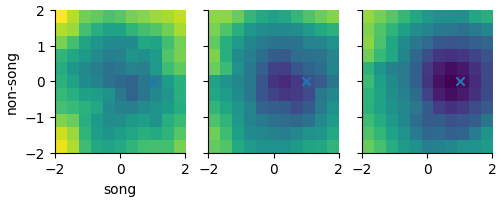

In [14]:
fig, ax = plt.subplots(1, ret_rand.shape[0], figsize=(5, 2), sharey='all', sharex='all')
for i in range(ret_rand.shape[0]):
    ax[i].imshow(ret_rand[i], aspect='auto', origin='lower', 
                 vmin=ret_rand.min(), vmax=ret_rand.max(), 
                 extent=(pert_vals_rand[0][0], pert_vals_rand[0][-1], 
                         pert_vals_rand[1][0], pert_vals_rand[1][-1]))
    ax[i].scatter(1, 0, marker='x')
ax[0].set(ylabel='non-song', xlabel='song')

In [15]:
def plot_3d_response(pert_vals, ret_, ylabel, zmax, 
                     levels=(1, 2, 3, 4), figsize=(8,3)):
    fig, ax = plt.subplots(1, 4, subplot_kw={'projection': '3d'}, figsize=figsize, 
                           constrained_layout=True)
    ts_loc = 1 # or if the axis is normalized, np.linalg.norm(syl)
    ret = ret_.copy()
    ret[ret > zmax+0.5] = np.nan
    x, y = np.meshgrid(*pert_vals, indexing='ij') 
    for i, n in enumerate(('before', 'during', 'after', '')):
        j = i if i <= 2 else 2
        ax[i].view_init(elev=20, azim=45, roll=0)
        ax[i].plot_surface(x, y, ret[j], cmap='plasma', alpha=0.8, 
                           antialiased=False)
        ax[i].contour(x, y, ret[j], zdir='z', levels=levels, offset=0, 
                      cmap='plasma', zorder=-1)
        ax[i].scatter(0, ts_loc, zs=0, marker='o', s=40, color='r', alpha=0.8)
        ax[i].set(xticks=[], yticks=[], zticks=[], zlim=[0, zmax])
        if i <= 2: # subplot title
            ax[i].text(0, 0, zmax+5, n + ' learning', fontsize=11, ha='center')
        # Style setting 
        ax[i].set_box_aspect(aspect=None, zoom=0.95)
        ax[i].computed_zorder = False
        ax[i].grid(False)
        ax[i].xaxis.pane.fill = False
        ax[i].yaxis.pane.fill = False
        ax[i].zaxis.pane.fill = False
    ax[0].plot([0,x.min()], [ts_loc]*2, [0, 2], ls=':', c='r', lw=2)
    ax[0].text(x.min(), ts_loc, 2, 'tutor song', 
               color='r', ha='center', va='bottom')
    # plot trajectory
    init_coord = (np.array([x[0,3], y[0,3], ret[-1,0,3]]) +\
                  np.array([x[1,2], y[1,2], ret[-1,1,2]])) / 2
    if np.isnan(init_coord[2]):
        init_coord[2] = zmax
    ax[3].text(*(init_coord+[0,0,3]), 'immature\nsong', 
               color='navy', ha='center', va='bottom')
    ax[3].scatter(*init_coord, marker='o', s=40, color='navy')
    fig.text(0.0, 0.3, '\npopulation response', ha='center', rotation=90)
    fig.text(0.07, 0.17, 'song\nvariation', ha='center', rotation=-25)
    fig.text(0.2, 0.35, ylabel, ha='center', va='top', rotation=22)
    return fig, ax

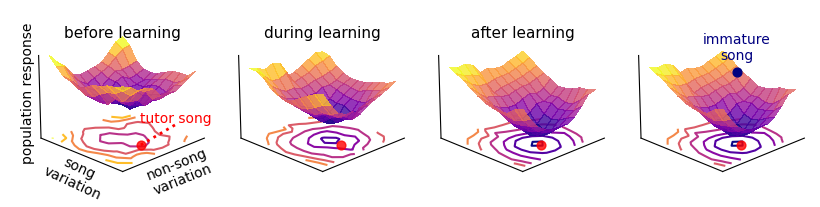

In [16]:
fig, ax = plot_3d_response(pert_vals_rand, ret_rand, 
                           ylabel='non-song\nvariation', 
                           zmax=ret_rand.max(),
                           levels=np.linspace(np.ceil(ret_rand.min()), 
                                              np.floor(ret_rand.max()), num=8))
fig.savefig('../svg/landscape.svg', transparent=True)